In [12]:
import os
import openai
from PIL import Image
import requests
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import torch
import math
from models.blip_itm import blip_itm
from models.blip import blip_decoder
from dotenv import load_dotenv

load_dotenv()

openai.api_key = os.getenv('OPENAI_API_KEY')

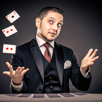

In [11]:
# Generate an image prompt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
prompt = "Magician performing a magic trick with a deck of cards." 

response = openai.Image.create(
    prompt=prompt,
    n=1,
    size="512x512"
)

target_image_url = response['data'][0]['url']
raw_image_url = Image.open(requests.get(target_image_url, stream=True).raw).convert('RGB') 
w,h = raw_image_url.size
display(raw_image_url.resize((w//5,h//5)))
# Save image to disk 
raw_image_url.save('target_image.jpg')

transform = transforms.Compose([
    transforms.Resize((512,512),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ]) 
image = transform(raw_image_url).unsqueeze(0).to(device) 


In [13]:
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
image_size = 512

model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)        

reshape position embedding from 196 to 1024
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth


In [14]:
captions = []
num_caption = 5

with torch.no_grad():
    for i in range(num_caption):
        caption = model.generate(image, sample=True, num_beams=3, max_length=20, min_length=5, top_p=0.9)
        captions.append(caption[0])
        print('caption: ', caption)

caption:  ['someone throwing cards in the air']
caption:  ['a man that is confused about something']
caption:  ['a man sitting with four cards in his hand']
caption:  ['a man wearing a suit and a red tie and holding four cards']
caption:  ['a man with hands in the air']


In [15]:
image_url = []
for i in range(len(captions)):
    response = openai.Image.create(
        prompt=captions[i],
        n=1,
        size="512x512"
    )
    img_url = response['data'][0]['url']
    image_url.append(img_url)

In [16]:
def load_demo_image(url, image_size,device):
    raw_image = Image.open(requests.get(url, stream=True).raw)     
    return raw_image

In [17]:
from sklearn.preprocessing import normalize
import clip

class ImageSimilarity:
    def __init__(self):
        self.image_embedder, self.image_embedder_preprocess = clip.load("ViT-B/32", device="cuda")
        
    def get_image_embedding(self, image):
        preprocessed_image = self.image_embedder_preprocess(image).unsqueeze(0).to("cuda")
        embedding = self.image_embedder.encode_image(preprocessed_image)
        return normalize(embedding.cpu().detach().numpy())[0]
    
    def get_image_similarity_score(self, image1, image2):
        embedding1 = self.get_image_embedding(image1)
        embedding2 = self.get_image_embedding(image2)
        return embedding1.dot(embedding2)

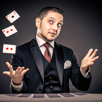

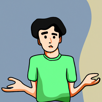

0.689


In [18]:
image_similarity = ImageSimilarity()
target = load_demo_image(target_image_url,512,device)
image_2 = load_demo_image(image_url[1],512,device)



w,h = target.size
display(target.resize((w//5,h//5)))
display(image_2.resize((w//5,h//5)))
print(image_similarity.get_image_similarity_score(target,image_2))

In [19]:
target = load_demo_image(target_image_url,512,device)
top_similarity = (0,0)
for i in range(len(image_url)):
    image_2 = load_demo_image(image_url[i],512,device)
    similarity = image_similarity.get_image_similarity_score(target,image_2)
    print("Caption: ", captions[i], '\tSimilarity Score: ', similarity)
    if(top_similarity[1] < similarity):
        top_similarity = (i, similarity)
print(top_similarity)

Caption:  someone throwing cards in the air 	Similarity Score:  0.889
Caption:  a man that is confused about something 	Similarity Score:  0.689
Caption:  a man sitting with four cards in his hand 	Similarity Score:  0.8027
Caption:  a man wearing a suit and a red tie and holding four cards 	Similarity Score:  0.9
Caption:  a man with hands in the air 	Similarity Score:  0.6846
(3, 0.9)


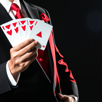

Caption:  a man wearing a suit and a red tie and holding four cards


In [94]:
best_image = load_demo_image(image_url[top_similarity[0]],512,device)
# best_image.save('best_image.jpg')
w,h = best_image.size
display(best_image.resize((w//5,h//5)))
print("Caption: ", captions[top_similarity[0]])

In [20]:
from models.blip_vqa import blip_vqa

model_vqa_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'
    
model_vqa = blip_vqa(pretrained=model_vqa_url, image_size=image_size, vit='base')
model_vqa.eval()
model_vqa = model_vqa.to(device)

reshape position embedding from 900 to 1024
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth


In [70]:
question = "Who is the subject"

with torch.no_grad():
    subject = model_vqa(image, question, train=False, inference='generate') 
    print('answer: '+subject[0])

answer: man


In [72]:
question = "Describe what the subject is doing"

with torch.no_grad():
    action = model_vqa(image, question, train=False, inference='generate') 
    print('answer: '+action[0])

answer: juggling


In [73]:
question = "Where is the image?"

with torch.no_grad():
    setting = model_vqa(image, question, train=False, inference='generate') 
    print('answer: '+setting[0])

answer: in front of man


In [74]:
question = "Describe the composition of the image"

with torch.no_grad():
    comp = model_vqa(image, question, train=False, inference='generate') 
    print('answer: '+comp[0])

answer: action


In [75]:
question = "Describe the background of the image"

with torch.no_grad():
    bg = model_vqa(image, question, train=False, inference='generate') 
    print('answer: '+bg[0])

answer: black


In [76]:
question = "How close is the subject"

with torch.no_grad():
    position = model_vqa(image, question, train=False, inference='generate') 
    print('answer: '+position[0])

answer: very close


In [77]:
question = "What is the style of the image"

with torch.no_grad():
    style = model_vqa(image, question, train=False, inference='generate') 
    print('answer: '+style[0])

answer: artistic


In [78]:
question = "What is the " + subject[0] + " wearing?"

with torch.no_grad():
    subject_description = model_vqa(image, question, train=False, inference='generate') 
    print('answer: '+subject_description[0])

answer: suit


In [88]:
question = "What is the " + subject[0] + " playing with?"

with torch.no_grad():
    object = model_vqa(image, question, train=False, inference='generate') 
    print('answer: '+object[0])

answer: cards


In [91]:
def generate_new_image_similarity(new_prompt, target, num=0):
    response = openai.Image.create(
        prompt=new_prompt,
        n=1,
        size="512x512"
    )
    new_image_url = response['data'][0]['url']
    new_image = load_demo_image(new_image_url,512,device)
    similarity = image_similarity.get_image_similarity_score(target,new_image)
    new_image = Image.open(requests.get(new_image_url, stream=True).raw).convert('RGB') 
    new_image.save('new_image'+str(num)+'.jpg')
    w,h = new_image.size
    display(new_image.resize((w//5,h//5)))
    print('Similarity: ', similarity)
    
    return similarity

Target:


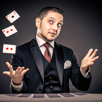

Original:  a man wearing a suit and a red tie and holding four cards
Similarity:  0.9


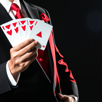

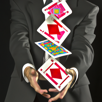

Similarity:  0.8345


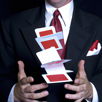

Similarity:  0.845


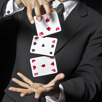

Similarity:  0.9053


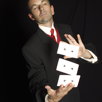

Similarity:  0.816


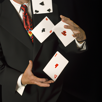

Similarity:  0.857


In [92]:
print('Target:')
display(target.resize((w//5,h//5)))
print('Original: ', captions[top_similarity[0]])
print('Similarity: ', top_similarity[1])
image_original = load_demo_image(image_url[top_similarity[0]],512,device)
display(image_original.resize((w//5, h//5)))
for i in range(5):
    # join the prompt with the asked questions
    new_prompt = ';' + subject[0] + ';' + action[0] + ';' + setting[0] + ';' + comp[0] + ';' + bg[0] + ';' + position[0] + ';' + style[0] + ';' + subject_description[0] + ';' + object[0]
    generate_new_image_similarity(captions[top_similarity[0]] + new_prompt , target, i)

In [95]:
print(captions[top_similarity[0]] + new_prompt)

a man wearing a suit and a red tie and holding four cards;man;juggling;in front of man;action;black;very close;artistic;suit;cards
